In [6]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from GWForge.population.redshift import Redshift
import bilby
import numpy as np
import pylab as plt
import os
from glob import glob
import seaborn as sns
import pandas as pd
import dill
from tqdm import tqdm
from scipy.stats import ncx2
from pycbc.waveform import get_fd_waveform

In [7]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#study_label = 'CE4020ET123_CoBA10_SNR_2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_corrected_td'
study_label = 'LHI_Asharp_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_corrected_td'

In [8]:
z_max = 10
gwf_z = Redshift(redshift_model='MadauDickinson', 
                 local_merger_rate_density=22, 
                 maximum_redshift=z_max, 
                 gps_start_time=0)
gwf_z_prob = gwf_z.coalescence_rate()

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:18

In [9]:
z_grid = np.arange(0, z_max, 0.001)
p_z = bilby.core.prior.Interped(z_grid, gwf_z_prob(z_grid))

## Check the probability function against input population

/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


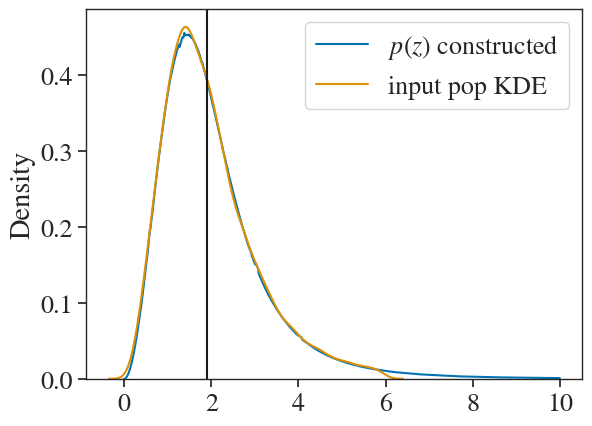

In [10]:
#with h5py.File(glob(os.path.join(project_dir, 'input_population', 'BBH', '2_pop*.h5'))[0], 'r') as f:
with h5py.File(glob(os.path.join(project_dir, 'input_population', 'BBH', '1_pop*.h5'))[0], 'r') as f:
    input_z = f['redshift'][:]
plt.plot(z_grid, p_z.probability_density(z_grid), label='$p(z)$ constructed')
sns.kdeplot(input_z, label='input pop KDE')
plt.axvline(1.9, c='k')
plt.legend()

## Get SNRs, masses, and redshift

In [12]:
#dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
dets = ['L1', 'H1', 'I1']
injected_data = {'total':{}}
select_params = ['distance','redshift', 'srcmass1', 'srcmass2', 'srcmtotal']

very_high_SNR_val = 1000
#very_high_SNR_val = 4000
weird_points = {'index':[], 'params':[]}
for det in dets + ['network']:
    select_params.append(f'SNR_{det}')
    select_params.append(f'SNR_mf_{det}')
    select_params.append(f'SNR_mf_from_opt_{det}')
    
for param in select_params:
    injected_data['total'][param] = []
    for i in list(range(400)):
        file_name = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 
                                 'SNR_output_files_XPHM', 
                                 study_label.replace('_Asharp', ''), 
                                 f'{study_label.replace("_Asharp", "")}_part{i}_SNR_data.h5')
        with h5py.File(file_name, 'r') as f:
            injected_data['total'][param].append(f['results'][param][:])
            if param == select_params[0]: #just need to run the code block once hence this if statement
                weird_idxs_in_file = np.where(f['results']['SNR_network'][()] > very_high_SNR_val)[0]
                if len(weird_idxs_in_file) != 0:
                    weird_points['index'].extend(list(weird_idxs_in_file+10000*i))
                    for idx in weird_idxs_in_file:
                        weird_points['params'].append({key:f['results'][key][idx] for key in f['results'].keys()})
    injected_data['total'][param] = np.concatenate(injected_data['total'][param])

In [13]:
pd.DataFrame(injected_data['total'])[injected_data['total']['SNR_network']>very_high_SNR_val]

,distance,redshift,srcmass1,srcmass2,srcmtotal,SNR_L1,SNR_mf_L1,SNR_mf_from_opt_L1,SNR_H1,SNR_mf_H1,SNR_mf_from_opt_H1,SNR_I1,SNR_mf_I1,SNR_mf_from_opt_I1,SNR_network,SNR_mf_network,SNR_mf_from_opt_network
133905,21335.726176,2.542893,6.691564,2.387718,9.079282,1.600607e+09,1.600607e+09,1.600607e+09,2.131004e+09,2.131004e+09,2.131004e+09,4.608326e+08,4.608326e+08,4.608326e+08,2.704715e+09,2.704715e+09,2.704715e+09
269143,14176.697143,1.817682,10.600293,3.844439,14.444731,4.161213e+10,4.161213e+10,4.161213e+10,3.390000e+10,3.390000e+10,3.390000e+10,2.312473e+10,2.312473e+10,2.312473e+10,5.844256e+10,5.844256e+10,5.844256e+10
2438425,14969.468515,1.900313,7.512449,3.411334,10.923783,9.763154e+02,9.774241e+02,9.757589e+02,6.371309e+02,6.386243e+02,6.359031e+02,1.021143e+03,1.021721e+03,1.020576e+03,1.549794e+03,1.551487e+03,1.548565e+03
3989024,17335.641479,2.143098,9.673509,7.547384,17.220893,1.925652e+29,1.925652e+29,1.925652e+29,2.204568e+29,2.204568e+29,2.204568e+29,1.596727e+29,1.596727e+29,1.596727e+29,3.334335e+29,3.334335e+29,3.334335e+29


In [14]:
np.all([weird_points['index'], pd.DataFrame(injected_data['total'])[injected_data['total']['SNR_network']>very_high_SNR_val].index])

True

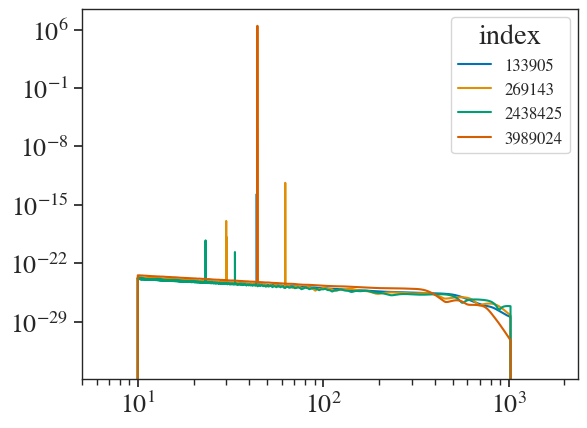

In [15]:
for idx, params in zip(weird_points['index'], weird_points['params']):
    params['approximant'] = 'IMRPhenomXPHM'
    hp, hc = get_fd_waveform(**params)
    plt.loglog(hp.sample_frequencies, abs(hp), label=idx)
    plt.xlim(5, )
    plt.legend(title='index', fontsize=12)

### Remove the weird data points

In [16]:
for key, arr in injected_data['total'].items():
    injected_data['total'][key] = np.delete(arr, weird_points['index'])

### Plot SNRs

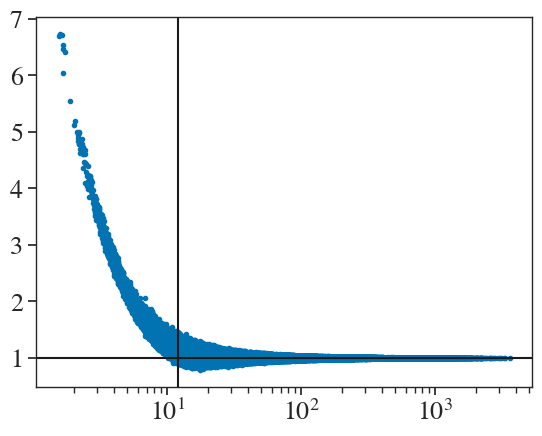

In [21]:
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_network']/injected_data['total']['SNR_network'], '.')
plt.xscale('log')
plt.axvline(12, color='k')
plt.axhline(1, color='k')

### Calculate MF SNRs from Optimal SNRs

In [9]:
def mf_snr_from_opt_snr(opt_snr, method='chisq'):
    """
    Choose method from ['chisq', 'normal']
    """
    if method == 'normal':
        mf_snr = np.random.normal(loc=opt_snr, scale=1.0)
    elif method == 'chisq':
        mf_snr_sq = ncx2.rvs(2, opt_snr**2)
        mf_snr = np.sqrt(mf_snr_sq)
    return(mf_snr)

In [10]:
#dets = ['L1', 'H1', 'I1']
dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
for det in dets:
    injected_data['total'][f'SNR_mf_from_opt_{det}'] = []
injected_data['total']['SNR_mf_from_opt_network'] = []

for event in tqdm(range(len(injected_data['total']['SNR_network']))):
    snr_netw_sq = 0
    for det in dets:
        snr_det = mf_snr_from_opt_snr(injected_data['total'][f'SNR_{det}'][event])
        injected_data['total'][f'SNR_mf_from_opt_{det}'].append(snr_det)
        snr_netw_sq += snr_det**2
    injected_data['total']['SNR_mf_from_opt_network'].append(np.sqrt(snr_netw_sq))

for key in injected_data['total'].keys():
    if 'mf_from_opt' in key:
        injected_data['total'][key] = np.array(injected_data['total'][key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000000/2000000 [06:49<00:00, 4887.05it/s]


### Plot SNRs

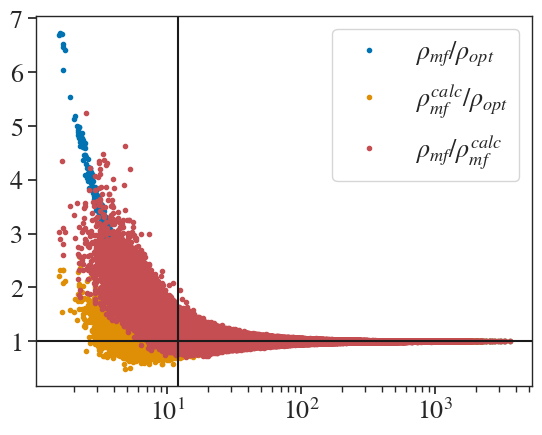

In [22]:
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_network']/injected_data['total']['SNR_network'], 
         '.', label='$\\rho_{mf}/\\rho_{opt}$')
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_from_opt_network']/injected_data['total']['SNR_network'], 
         '.', label='$\\rho_{mf}^{calc}/\\rho_{opt}$')
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_network']/injected_data['total']['SNR_mf_from_opt_network'], 
         '.', label='$\\rho_{mf}/\\rho_{mf}^{calc}$', color='r')
plt.xscale('log')
plt.axvline(12, color='k')
plt.axhline(1, color='k')
plt.legend(loc=1)

## Get detected population for injections

In [17]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [18]:
#injected_data['detected'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='opt')
#injected_data['detected_mf'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='mf')
injected_data['detected_mf_from_opt'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='mf_from_opt')

['SNR_mf_from_opt_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_network']


In [19]:
#len(injected_data['detected']['redshift']), len(injected_data['detected_mf']['redshift']), len(injected_data['detected_mf_from_opt']['redshift'])
len(injected_data['detected_mf_from_opt']['redshift'])

559800

## Create gwpopulation injection prior for redshift

In [20]:
#injected_data['detected']['p_z'] = p_z.probability_density(injected_data['detected']['redshift'])
#injected_data['detected_mf']['p_z'] = p_z.probability_density(injected_data['detected_mf']['redshift'])
injected_data['detected_mf_from_opt']['p_z'] = p_z.probability_density(injected_data['detected_mf_from_opt']['redshift'])

/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, '$z$')

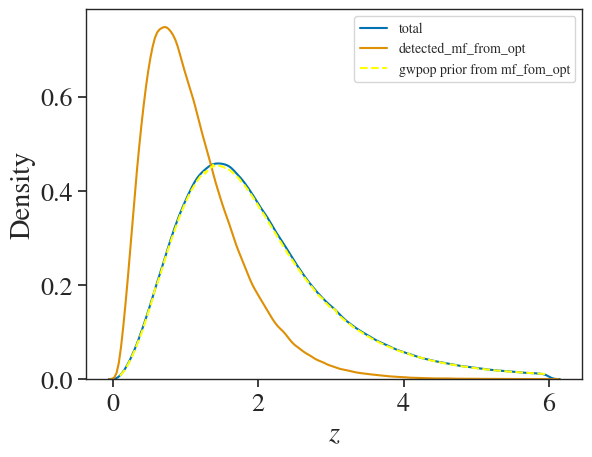

In [21]:
sns.kdeplot(injected_data['total']['redshift'], label='total')
#sns.kdeplot(injected_data['detected']['redshift'], label='detected')
sns.kdeplot(injected_data['detected_mf_from_opt']['redshift'], label='detected_mf_from_opt')
#sort_idx = np.argsort(injected_data['detected']['redshift'])
#plt.plot(np.array(injected_data['detected']['redshift'])[sort_idx], 
#         np.array(injected_data['detected']['p_z'])[sort_idx], label='gwpop prior')
sort_idx_mf = np.argsort(injected_data['detected_mf_from_opt']['redshift'])
plt.plot(np.array(injected_data['detected_mf_from_opt']['redshift'])[sort_idx_mf], 
         np.array(injected_data['detected_mf_from_opt']['p_z'])[sort_idx_mf], label='gwpop prior from mf_fom_opt', ls='--', c='yellow')
plt.legend(loc=1, fontsize=10)
plt.xlabel('$z$')

### Divide injections into mass bands

In [22]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [23]:
injected_data['detected_mf_from_opt'].keys()

Index(['distance', 'redshift', 'srcmass1', 'srcmass2', 'srcmtotal', 'SNR_L1',
       'SNR_mf_L1', 'SNR_mf_from_opt_L1', 'SNR_H1', 'SNR_mf_H1',
       'SNR_mf_from_opt_H1', 'SNR_I1', 'SNR_mf_I1', 'SNR_mf_from_opt_I1',
       'SNR_network', 'SNR_mf_network', 'SNR_mf_from_opt_network', 'p_z'],
      dtype='object')

In [24]:
mass_ranges = ['<40', '40-80', '>80']
injected_data['mass_select'] = {}
print('Total detected events =', len(injected_data['detected_mf_from_opt']))
for m_range in mass_ranges:
    print(m_range)
    injected_data['mass_select'][m_range] = {'detected_mf_from_opt': injected_data['detected_mf_from_opt'][slice_mtotal_pop(injected_data['detected_mf_from_opt']['srcmtotal'], m_range)].reset_index().rename(columns={'index':'old_index'})}
    injected_data['mass_select'][m_range]['total'] = pd.DataFrame(injected_data['total'])[slice_mtotal_pop(injected_data['total']['srcmtotal'], m_range)]
    print('Total =', len(injected_data['mass_select'][m_range]['total']))
    print('Detected =', len(injected_data['mass_select'][m_range]['detected_mf_from_opt']), '\n')

Total detected events = 559800
<40
Total = 3405654
Detected = 290025 

40-80
Total = 554599
Detected = 244965 

>80
Total = 39743
Detected = 24810 



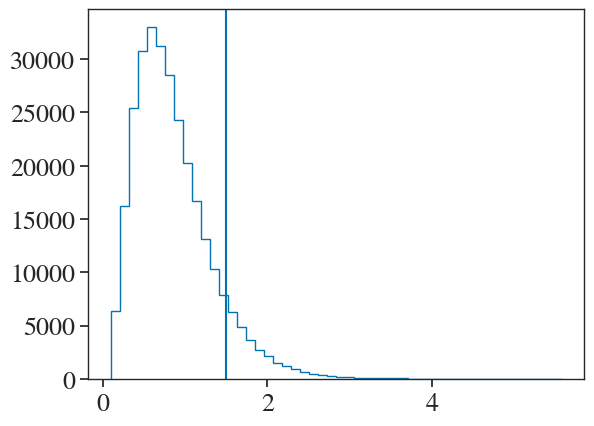

In [29]:
plt.hist(injected_data['mass_select']['<40']['detected_mf_from_opt']['redshift'], bins=50, histtype=u'step');
plt.axvline(1.5)

In [37]:
injected_data['mass_select']['<40']['detected_mf_from_opt'][injected_data['mass_select']['<40']['detected_mf_from_opt']['redshift'] > 1.5]

,old_index,distance,redshift,srcmass1,srcmass2,srcmtotal,SNR_L1,SNR_mf_L1,SNR_mf_from_opt_L1,SNR_H1,SNR_mf_H1,SNR_mf_from_opt_H1,SNR_I1,SNR_mf_I1,SNR_mf_from_opt_I1,SNR_network,SNR_mf_network,SNR_mf_from_opt_network,p_z
18,362,18762.682314,2.287103,18.573709,13.277974,31.851683,8.374561,9.143796,9.608271,8.051719,7.658091,9.485768,4.593868,4.793552,3.758173,12.492681,12.854318,14.015082,0.297120
19,402,16223.825680,2.029689,19.613750,7.918473,27.532223,6.833425,5.833263,5.368048,6.420521,6.452320,6.794226,6.120319,7.165022,8.408180,11.197191,11.269292,12.069588,0.362543
56,844,22876.212789,2.693963,17.379506,14.729696,32.109202,5.916877,5.464349,7.936395,6.700615,6.308765,8.046131,4.166886,4.808237,4.926126,9.862586,9.632173,12.328556,0.204771
80,1249,12469.533203,1.637156,13.800535,7.664756,21.465291,7.436717,6.234062,8.073245,7.156084,7.396873,7.702068,6.273021,7.285776,5.095160,12.077462,12.110318,12.266206,0.440998
115,1791,16371.840591,2.044853,13.089931,11.683890,24.773821,7.577916,5.251638,7.950285,6.536342,7.560101,6.494156,7.361227,6.945254,8.104956,12.423214,11.531322,13.079427,0.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289971,3999341,11483.658353,1.531065,16.901258,9.849166,26.750424,7.054938,5.364976,9.512538,5.490393,6.009683,6.454736,9.518272,10.588603,9.440327,13.058103,13.304803,14.875207,0.450690
289975,3999384,15872.784192,1.993642,18.480125,15.061649,33.541774,6.256410,4.943700,7.230320,8.153902,7.337127,8.137655,5.743605,5.054765,6.098200,11.773605,10.189419,12.477460,0.371078
289987,3999566,20417.587984,2.452146,12.160332,9.979148,22.139481,7.630627,7.636469,6.941052,7.533854,7.858043,9.099052,4.102205,5.986380,5.685326,11.481006,12.486042,12.778649,0.257449
289992,3999616,16092.646259,2.016233,20.971963,15.512980,36.484943,10.386097,10.693105,10.083696,9.441723,9.090238,9.464829,8.375013,7.182725,10.784928,16.344968,15.765991,17.537918,0.365776


In [31]:
injected_data['mass_select']['<40']['detected_mf_from_opt']

,old_index,distance,redshift,srcmass1,srcmass2,srcmtotal,SNR_C1,SNR_mf_C1,SNR_mf_from_opt_C1,SNR_CE20,...,SNR_E2,SNR_mf_E2,SNR_mf_from_opt_E2,SNR_E3,SNR_mf_E3,SNR_mf_from_opt_E3,SNR_network,SNR_mf_network,SNR_mf_from_opt_network,p_z
0,0,34971.731339,3.840791,8.064058,7.082899,15.146957,12.694008,14.113959,12.515636,1.838204,...,6.127218,5.789649,7.637408,5.568535,6.485084,5.207481,16.968564,19.885226,18.173781,0.065914
1,1,7182.881216,1.046449,19.114822,17.404615,36.519437,60.927642,62.174799,62.929630,32.765914,...,17.763986,18.731959,18.278352,8.676431,9.031545,8.370244,75.002696,76.165126,76.255791,0.390692
2,2,5658.795383,0.862218,11.155786,4.152489,15.308275,19.817854,20.006587,19.707337,12.635488,...,24.457277,24.302324,24.026713,26.431177,27.079754,25.675369,49.465379,50.496134,48.634262,0.321015
3,3,6423.500223,0.955764,7.375719,4.499035,11.874755,25.782438,25.299359,26.365007,6.966708,...,13.093519,13.246186,12.793952,6.640959,6.964295,6.128014,32.627350,33.239228,32.654591,0.359424
4,4,8411.827110,1.189360,10.472220,8.447725,18.919945,52.922207,53.572410,52.722699,31.610826,...,5.777859,5.383771,6.063753,2.928397,4.510352,1.028723,62.363425,63.095375,63.517864,0.427423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622572,1999989,23240.638923,2.729496,7.950645,2.917273,10.867918,21.156108,20.716600,21.870102,15.770659,...,7.461762,7.864954,6.657751,7.095186,5.971778,7.641353,28.993901,29.022272,30.435505,0.197832
1622573,1999990,20356.359313,2.446074,8.031146,2.582215,10.613361,22.909347,22.330356,23.309714,9.908781,...,7.717501,8.667607,6.327092,8.122806,8.543557,9.152089,28.523615,27.774308,29.377303,0.258584
1622574,1999991,12668.430353,1.658387,10.395547,9.977420,20.372966,54.694382,56.481856,55.229461,22.465295,...,15.303712,14.573869,15.171016,10.892983,11.191665,8.681765,62.932392,64.296721,63.234812,0.438301
1622575,1999992,24745.052018,2.875412,7.459083,3.284954,10.744038,15.558874,15.105379,14.187440,8.236330,...,2.394232,4.935958,1.868364,1.769850,5.400225,1.285532,18.004090,19.646138,17.932690,0.172203


## Write to file

#### Optimal SNR detected population

In [125]:
z_dict_write = {'redshift':np.array(injected_data['detected']['redshift']), 
                'prior':np.array(injected_data['detected']['p_z']),
                'total_generated':len(injected_data['total']['redshift'])}

In [126]:
z_dict_write

{'redshift': array([0.60420558, 1.15718353, 1.36790472, ..., 0.64030051, 1.32739309,
        1.5062418 ]),
 'prior': array([0.20164625, 0.42679907, 0.45821708, ..., 0.21798621, 0.45465871,
        0.4585973 ]),
 'total_generated': 1000000}

In [77]:
with open(os.path.join(project_dir, 'gwpopulation', 'BBH', 'detected_injections.pkl'), 'wb') as f:
    dill.dump(z_dict_write, f)

#### MF SNR detected population

In [15]:
z_dict_write_mf = {'redshift':np.array(injected_data['detected_mf']['redshift']), 
                'prior':np.array(injected_data['detected_mf']['p_z']),
                'total_generated':len(injected_data['total']['redshift'])}

In [16]:
z_dict_write_mf

{'redshift': array([3.84079076, 1.04644887, 0.86221836, ..., 1.39134291, 1.52781983,
        2.11487193]),
 'prior': array([0.06591428, 0.39069246, 0.32101525, ..., 0.45236422, 0.45093994,
        0.34119665]),
 'total_generated': 1000000}

In [17]:
with open(os.path.join(project_dir, 'gwpopulation', 'BBH', f'{study_label}_detected_injs_mf_SNR_1M_points.pkl'), 'wb') as f:
    dill.dump(z_dict_write_mf, f)

#### MF from opt SNR detected population

In [32]:
z_dict_write_mf_from_opt = {}
for m_range in mass_ranges:
    z_dict_write_mf_from_opt[m_range] = {'redshift':np.array(injected_data['mass_select'][m_range]['detected_mf_from_opt']['redshift']), 
                                         'prior':np.array(injected_data['mass_select'][m_range]['detected_mf_from_opt']['p_z']),
                                         'total_generated':len(injected_data['mass_select'][m_range]['total']['redshift'])}

In [33]:
z_dict_write_mf_from_opt

{'<40': {'redshift': array([3.84079076, 1.04644887, 0.86221836, ..., 1.65838668, 2.87541184,
         3.30768112]),
  'prior': array([0.06591428, 0.39069246, 0.32101525, ..., 0.43830115, 0.17220304,
         0.11069457]),
  'total_generated': 1703378},
 '40-80': {'redshift': array([2.96858567, 2.04589971, 0.59488276, ..., 4.70255385, 0.72418022,
         1.25634355]),
  'prior': array([0.15618689, 0.35806969, 0.19649015, ..., 0.02990285, 0.25790723,
         0.43947226]),
  'total_generated': 276766},
 '>80': {'redshift': array([4.9956343 , 2.89417961, 6.07744406, ..., 1.44365759, 1.48790466,
         3.51217908]),
  'prior': array([0.02315916, 0.16959954, 0.00977347, ..., 0.45295006, 0.45285676,
         0.09093102]),
  'total_generated': 19852}}

In [34]:
def mass_range_names(range_name):
    return(range_name.replace('<', 'below_').replace('>', 'above_'))

In [35]:
for m_range in mass_ranges:
    num_points = z_dict_write_mf_from_opt[m_range]['total_generated']
    m_range_name = mass_range_names(m_range)
    write_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'mass_bands', 'XPHM')
    os.makedirs(write_dir, exist_ok=True)
    with open(os.path.join(write_dir,
                           f'{study_label}_detected_injs_mf_from_opt_SNR_{num_points}_points_{m_range_name}.pkl'), 
              'wb') as f:
        dill.dump(z_dict_write_mf_from_opt[m_range], f)